In [ ]:
import sys

# Add the directory containing your file to the Python path
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

# Now you can import your module
!pip install lmfit
!pip install mtalg

import TCSPC


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 8.1 MB/s eta 0:00:00


In [ ]:
from TCSPC import *
plt.rcParams['figure.constrained_layout.use'] = True

In [ ]:
EGFP = Phasor([0.497,0.503],[2.43,3.07])

In [ ]:
from scipy.stats import poisson

time_path = "/content/drive/MyDrive/Maximum/EGFPt.csv"
tdata = np.loadtxt(time_path)

# Assuming EGFP.y2 is already a NumPy array
ydata = EGFP.y2


In [ ]:
def trim_rescale_data(tdata,ydata,r = 10,rescale = True):
    '''Trim and rescale data (if rescale ==True)
       tdata    EGFP.t
       ydata    EGFP.y2
       r        select points with y>r*max(y)
       rescale  True to rescale, False won't rescale'''
     #select points >r counts only
    ydata = ydata[ydata>r]
    #trim away IRF
    ydata = ydata[np.argmax(ydata):]
    #set tdata to same length, start from t = 0
    tdata = tdata[:len(ydata)]
    if rescale == True:
        yerr = ydata/ydata[0]*np.sqrt(1/ydata+1/ydata[0]) #error after scaling
        ydata = ydata/ydata[0] # scale y data such that the beginning is 1
    else:
        yerr = np.sqrt(ydata)
    weights = 1/yerr #weighted by 1/yerr, yerr is error after scaling ydata
    return tdata,ydata,weights

def exp(t, A, tau):
    return A * np.exp(-t/tau)

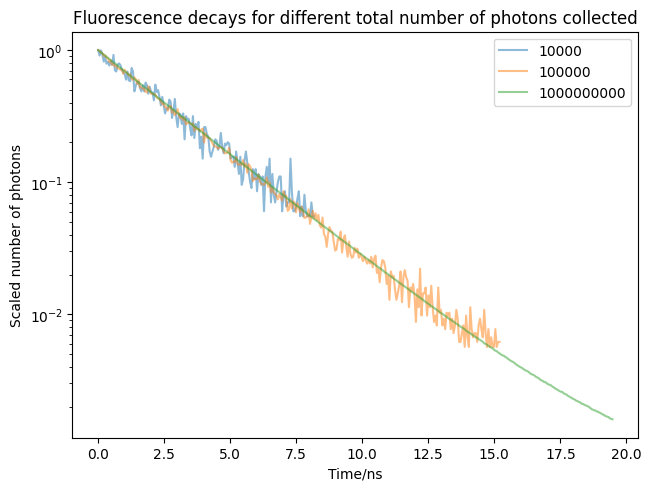

In [ ]:
for n_photon in [int(1e4),int(1e5),int(1e9)]:
    EGFP.n_photon = n_photon
    EGFP.multi_exp_data()
    tdata,ydata,weights = trim_rescale_data(EGFP.t,EGFP.y2,rescale = True)
    plt.plot(tdata,ydata,alpha = 0.5,label = str(n_photon))
plt.legend()
plt.title('Fluorescence decays for different total number of photons collected' )
plt.xlabel('Time/ns')
plt.ylabel('Scaled number of photons')
plt.yscale('log')

In [ ]:
def poisson_deviance_residual(observed, expected):
    '''Return Poisson deviance residual array for given observed data and expected (model) '''
    residual=  np.sign(observed-expected)*np.sqrt(abs(2 *  (observed* np.log(observed/ expected) - (observed- expected)))) #residual array
    return residual

def residual(p, t, data):
    '''Return residual array for lmfit.minimizer to minimize in the sum of squares sense
       Inputs:
       p         lmfit.Parameters() object
       t         time array (independent variable)
       data      data array to be fitted'''
    v = p.valuesdict() #obtain dictionary of parameter values
    expected = 0
    if 'c' in v:
        expected = v['c'] #constant background
    M = 1
    while f'A{M}' in v:
        expected += exp(t, v[f'A{M}'], v[f'tau{M}']) #add exponential component
        M += 1
    return poisson_deviance_residual(data, expected) #lmfit.minimizer minimize the residual array in the sum of squared sense

def LS_deviance_residual(observed, expected, weights):
    '''Return Poisson deviance residual array for given observed data and expected (model) '''
    residual = (observed - expected) * weights
    return residual

def LS_residual(p, t, data, weights=weights):
    '''Return residual array for lmfit.minimizer to minimize in the sum of squares sense
       Inputs:
       p         lmfit.Parameters() object
       t         time array (independent variable)
       data      data array to be fitted
       yerr      array of errors for data points'''
    v = p.valuesdict()  # obtain dictionary of parameter values
    expected = 0
    if 'c' in v:
        expected = v['c']  # constant background
    M = 1
    while f'A{M}' in v:
        expected += exp(t, v[f'A{M}'], v[f'tau{M}'])  # add exponential component
        M += 1
    return LS_deviance_residual(data, expected, weights)


def initial_params(M,A_guess,tau_guess,c_guess = 0,rescale = True,bg_removed = False):
    '''Create and return initial parameters of fit (lmfit.Parmaeters() object)
       Input:
       M          number of lifetime components
       A_guess    np.array of A1,...AM amplitudes guess
       tau_guess  np.array of tau1,...tauM lifetimes guess
       c_guess    constant background offset guess
       rescale    True if the ydata is rescaled
       bg_removed True if bg is removed
       '''
    p = lmfit.Parameters()
    if bg_removed == False:
        p.add_many(('c', c_guess, True, 0)) #constant background
    for i in range(1,M+1): #for each component
        p.add_many((f'A{i}', A_guess[i-1], True,0)) #amplitude
    for i in range(1,M+1):
        p.add_many((f'tau{i}', tau_guess[i-1], True, 0)) #lifetime
    if rescale == True:
        p[f'A{M}'].set(expr = f'1 {"".join([f"- A{i}" for i in range(1,M)])}') #fix the amplitude of last component
    return p

def chi2(params):
    '''Return chi2 from given parameters (np.array)'''
    M = int((len(params)-1)/2)
    p = initial_params(M,params[1:M+1],params[M+1:],c_guess=params[0],rescale = False)
    return np.dot(LS_residual(p, tdata, ydata),residual(p, tdata, ydata))

In [ ]:
!pip install numdifftools
import numdifftools
import numdifftools as nd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 1.1 MB/s eta 0:00:00


## bi-exp decay fit to EGFP

## Rescaled:
Life times are inaccurate

In [ ]:
EGFP.n_photon = int(1e5)
EGFP.multi_exp_data()
tdata,ydata,weights = trim_rescale_data(EGFP.t,EGFP.y2-EGFP.bg*EGFP.run_time/380)
p1 = initial_params(2,EGFP.amp,EGFP.tau)
p1['c'].set(value = 0, vary = False)
mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata), method='powell')

print(lmfit.fit_report(mi1))

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 224
    # data points      = 279
    # variables        = 3
    chi-square         = 0.14117280
    reduced chi-square = 5.1150e-04
    Akaike info crit   = -2111.32608
    Bayesian info crit = -2100.43245
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    c:     0 (fixed)
    A1:    0.57197583 (init = 0.497)
    A2:    0.42802417 == '1 - A1'
    tau1:  2.31696605 (init = 2.43)
    tau2:  3.25246720 (init = 3.07)


## Bi-exp - Not Rescaled:
Lifetimes are closer to true values, and chi-squared values are better - don't suggest overfitting.

In [ ]:
#generate data for a particular total collected photon number
EGFP.n_photon = int(1e5)
w,p = EGFP.multi_exp_data()

y_no_bg = EGFP.y2-EGFP.bg*EGFP.run_time/EGFP.n_bins
y_with_bg = EGFP.y2
tdata,ydata,weights = trim_rescale_data(EGFP.t,y_no_bg,rescale = False) #bg removed
p1 = initial_params(2,np.max(EGFP.y2)*EGFP.amp,EGFP.tau,rescale = False)
p1['c'].set(value = 0, vary = False)
mi2 = lmfit.minimize(residual, p1, args=(tdata, ydata),method = 'powell')

print(lmfit.fit_report(mi2))

tdata,ydata,weights = trim_rescale_data(EGFP.t,y_with_bg,rescale = False) #bg removed
p1['c'].set(value = 0, vary = True)
mi2 = lmfit.minimize(residual, p1, args=(tdata, ydata),method = 'powell')
print(lmfit.fit_report(mi2))

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 239
    # data points      = 280
    # variables        = 4
    chi-square         = 276.440634
    reduced chi-square = 1.00159650
    Akaike info crit   = 4.41781745
    Bayesian info crit = 18.9569759
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    c:     0 (fixed)
    A1:    968.366865 (init = 919.45)
    A2:    919.728873 (init = 930.55)
    tau1:  2.37515827 (init = 2.43)
    tau2:  3.16228631 (init = 3.07)
[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 285
    # data points      = 285
    # variables        = 5
    chi-square         = 276.897946
    reduced chi-square = 0.98892123
    Akaike info crit   = 1.78055170
    Bayesian in

## Mono-exp decay fit - Not rescaled

In [ ]:
p1 = initial_params(1,[np.max(ydata)],EGFP.tau,rescale = False)
mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata),method = 'powell')
print(lmfit.fit_report(mi1))

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 196
    # data points      = 285
    # variables        = 3
    chi-square         = 277.920676
    reduced chi-square = 0.98553431
    Akaike info crit   = -1.16873173
    Bayesian info crit = 9.78873581
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    c:     3.63990114 (init = 0)
    A1:    1872.40919 (init = 1850)
    tau1:  2.75724114 (init = 2.43)


## Tri-exp Not rescaled

In [ ]:
p1 = initial_params(3,[np.max(EGFP.y2*0.49),np.max(EGFP.y2)*0.51,100],EGFP.tau+[10],rescale = False)
mi3 = lmfit.minimize(residual, p1, args=(tdata, ydata),method = 'powell')

print(lmfit.fit_report(mi3))

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 412
    # data points      = 285
    # variables        = 7
    chi-square         = 276.995113
    reduced chi-square = 0.99638530
    Akaike info crit   = 5.88054441
    Bayesian info crit = 31.4479687
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    c:     2.77469764 (init = 0)
    A1:    977.609510 (init = 906.5)
    A2:    883.856278 (init = 943.5)
    A3:    16.9188045 (init = 100)
    tau1:  2.52835612 (init = 2.43)
    tau2:  2.99563284 (init = 3.07)
    tau3:  3.44899414 (init = 10)


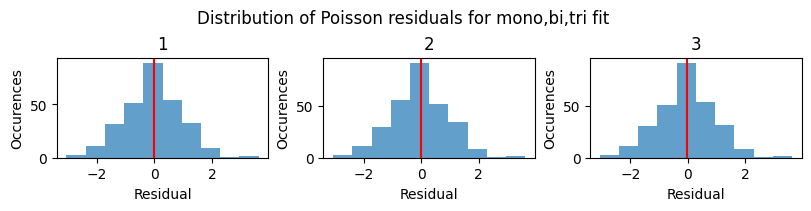

In [ ]:
fig,ax = plt.subplots(ncols=3,figsize = (8,2))
fig.suptitle('Distribution of Poisson residuals for mono,bi,tri fit ')
for i in range(3):
    mi = [mi1,mi2,mi3][i]
    resid = LS_residual(mi.params,tdata,ydata,weights)
    ax[i].hist(resid,alpha = 0.7)
    ax[i].axvline(np.mean(residual(mi.params,tdata,ydata)),c='r',label = 'mean')
    ax[i].set_title(range(1,4)[i])
    ax[i].set_xlabel('Residual')
    ax[i].set_ylabel('Occurences')

## Get 100 simulation at each point (bi-exp decay)


In [ ]:
def MLEfit(N,tdata,ydata,method ='powell',r=10,rescale=False):

    tdata, ydata, weights = trim_rescale_data(tdata,ydata, r=r, rescale=rescale)
    p1 = initial_params(N, [np.max(ydata * 0.49), np.max(ydata) * 0.51], EGFP.tau, rescale=rescale)
    mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata), method=method)
    par_dict = {k:[v.value] for k,v in mi1.params.items()} #turn params values into dict
    A_sum = sum([par_dict[f'A{j}'][0] for j in range(1,N+1)]) #sum all An
    for i in range(1,N+1):
      par_dict[f'A{i}'][0]=par_dict[f'A{i}'][0]/A_sum

    return pd.DataFrame.from_dict(par_dict)
MLEfit(2,EGFP.t,EGFP.sim_data[2])

,c,A1,A2,tau1,tau2
0,31.7367,0.48935,0.51065,2.424551,3.067372


In [ ]:
def MLEfit(N,tdata,ydata,method ='powell',r=10,rescale=False,bg=True):
    tdata, ydata, weights = trim_rescale_data(tdata,ydata, r=r, rescale=rescale)
    p1 = initial_params(N, np.max(ydata)*EGFP.amp, EGFP.tau, rescale=rescale)
    if bg == False: #background removed
      p1['c'].set(value = 0,vary = False)

    mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata), method=method)
    par_dict = {k:[v.value] for k,v in mi1.params.items()} #turn params values into dict
    A_sum = sum([par_dict[f'A{j}'][0] for j in range(1,N+1)]) #sum all An
    for i in range(1,N+1):
      par_dict[f'A{i}'][0]=par_dict[f'A{i}'][0]/A_sum

    return pd.DataFrame.from_dict(par_dict)

def LSfit(N,tdata,ydata,method ='powell',r=10,rescale=False,bg=True):
    tdata, ydata, weights = trim_rescale_data(tdata,ydata, r=r, rescale=rescale)
    p1 = initial_params(N, np.max(ydata)*EGFP.amp, EGFP.tau, rescale=rescale)
    if bg == False: #background removed
      p1['c'].set(value = 0,vary = False)

    mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata), method=method)
    par_dict = {k:[v.value] for k,v in mi1.params.items()} #turn params values into dict
    A_sum = sum([par_dict[f'A{j}'][0] for j in range(1,N+1)]) #sum all An
    for i in range(1,N+1):
      par_dict[f'A{i}'][0]=par_dict[f'A{i}'][0]/A_sum

    return pd.DataFrame.from_dict(par_dict)


def val_df(N,method='powell',sim_data=EGFP.sim_data,r=10,rescale=False,bg=True):
  '''Create dataframe of fitted parameters for 100 simulations'''
  df_list = []
  for j in range(100):
    df_list.append( MLEfit(N,EGFP.t,sim_data[j],method='powell',r=r,rescale=rescale,bg=bg))
    df= pd.concat(df_list).reset_index()
  return df.drop(['index'],axis =1)

#this would take 10 mins to run
N=2 #components
EGFP.y_list = np.zeros((20,100,380))
EGFP.y_no_bg_list = np.zeros((20,100,380))
n_photon_arr = np.logspace(4,9,20)
df_list = []
for i in range(len(n_photon_arr)):
  EGFP.n_photon = n_photon_arr[i]
  EGFP.repeat_sim(100)
  EGFP.y_list[i] = EGFP.sim_data
  EGFP.y_no_bg_list[i] = EGFP.sim_data-EGFP.bg*EGFP.run_time/EGFP.n_bins
  df =val_df(N,sim_data=EGFP.y_list[i])
  df_no_bg = val_df(N,sim_data=EGFP.y_no_bg_list[i],bg=False)
  df_rescale= val_df(N,sim_data=EGFP.y_list[i],rescale = True)
  df_no_bg_rescale= val_df(N,sim_data=EGFP.y_no_bg_list[i],r=30,rescale = True,bg=False)
  df_list.append([df,df_no_bg,df_rescale,df_no_bg_rescale])

In [ ]:
#read multi index csv
n_val_df    = pd.read_csv('/content/drive/MyDrive/Maximum/df/n_val_df.csv',index_col = [0,1])
n_info_df   = pd.read_csv('/content/drive/MyDrive/Maximum/df/n_info_df.csv',index_col = [0,1])
n_par_df    = pd.read_csv('/content/drive/MyDrive/Maximum/df/n_par_df.csv',index_col = [0,1,2])
n_phasor_df = pd.read_csv('/content/drive/MyDrive/Maximum/df/n_phasor_df.csv',header=[0, 1], index_col=[0,1])
mle_val_df = pd.read_csv('/content/drive/MyDrive/Maximum/df/mle_val_df.csv',header=[0, 1], index_col=[0,1])#concat 100 dfs of 100 repeated simulations for each photon number

In [ ]:
idx = pd.IndexSlice #extract df using pd.IndexSlice
#idx[n_photon_row,simulation_row]
#idx[case_col,par_col]
mle_val_df.loc(axis=1)[idx['bg',:]]  #get bg dataframe
n_phasor_df.loc(axis=1)[idx['bg',:]]

bg                    
             A1      tau1      tau2
0  0   0.503518  2.392791  3.036480
   1   0.491281  2.601363  2.924161
   2   0.505061  2.183123  3.282314
   3   0.509892  2.097513  3.330789
   4   0.491303  2.510380  3.038835
...         ...       ...       ...
19 95  0.496506  2.401079  3.112648
   96  0.496469  2.401793  3.112201
   97  0.496459  2.401499  3.112689
   98  0.496532  2.400494  3.113060
   99  0.496514  2.400892  3.112782

[2000 rows x 3 columns]

In [ ]:
new_df1 = mle_val_df.drop(mle_val_df[mle_val_df.no_bg_rescale.tau2>10].index) #drop rows where tau2 is anamolous
new_df1.dropna(inplace = True) #new df without anamolous values
np.unique(new_df1.isna())      #check no nan values

new_df2 = n_phasor_df.drop(n_phasor_df[n_phasor_df.no_bg.tau2>10].index) #drop rows where tau2 is anamolous
new_df2.dropna(inplace = True) #new df without anamolous values
np.unique(new_df1.isna())      #check no nan values

array([False])

<ipython-input-19-4b960e53b798>:21: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=0.85)
<ipython-input-19-4b960e53b798>:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


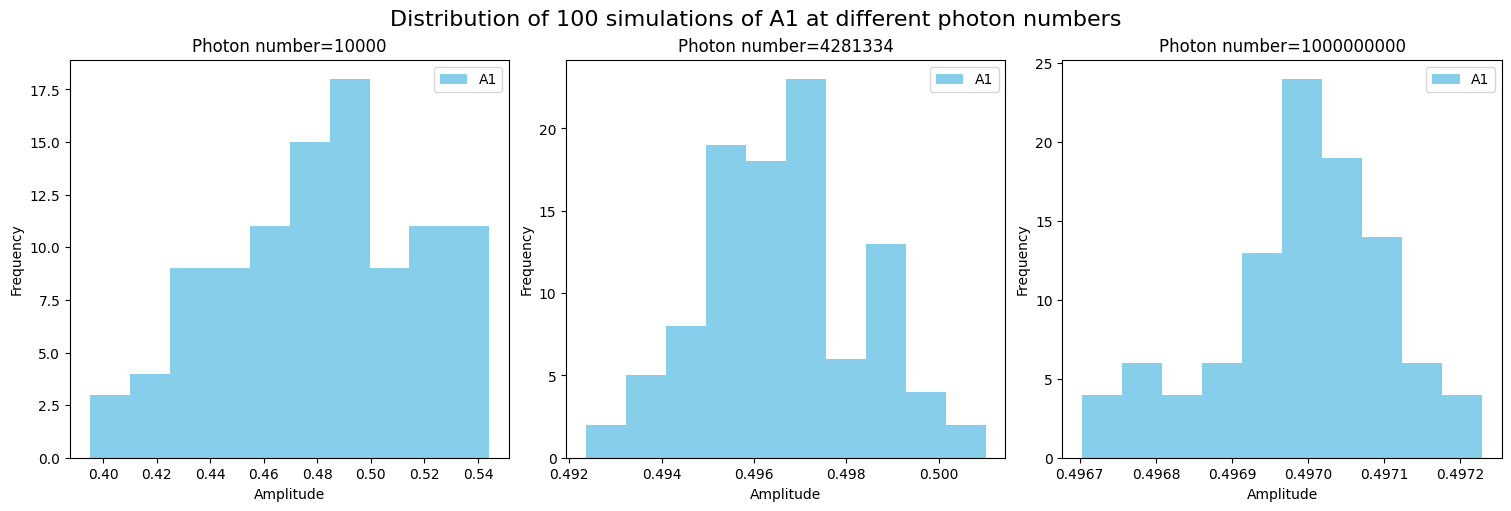

In [ ]:
# Setup for loop parameters
indices = [0, 10, 19]  # Indices for low, middle, high photon number
titles = ['Photon number=10000', 'Photon number=4281334', 'Photon number=1000000000']
colors = ['skyblue', 'skyblue', 'skyblue']  # Using the same color, but allows customization
bins = 10  # Assuming you want the same number of bins for each histogram

# Set up the subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

for i, (index, title) in enumerate(zip(indices, titles)):
    axs[i].hist(mle_val_df.loc[idx[index,:], idx['no_bg','A1']], bins=bins, color=colors[i])
    axs[i].set_xlabel('Amplitude')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(title)
    axs[i].legend(['A1'])

# Add a main title for the plots
fig.suptitle('Distribution of 100 simulations of A1 at different photon numbers', fontsize=16)

# Adjust layout to prevent overlapping
plt.subplots_adjust(top=0.85)

plt.tight_layout()
plt.show()

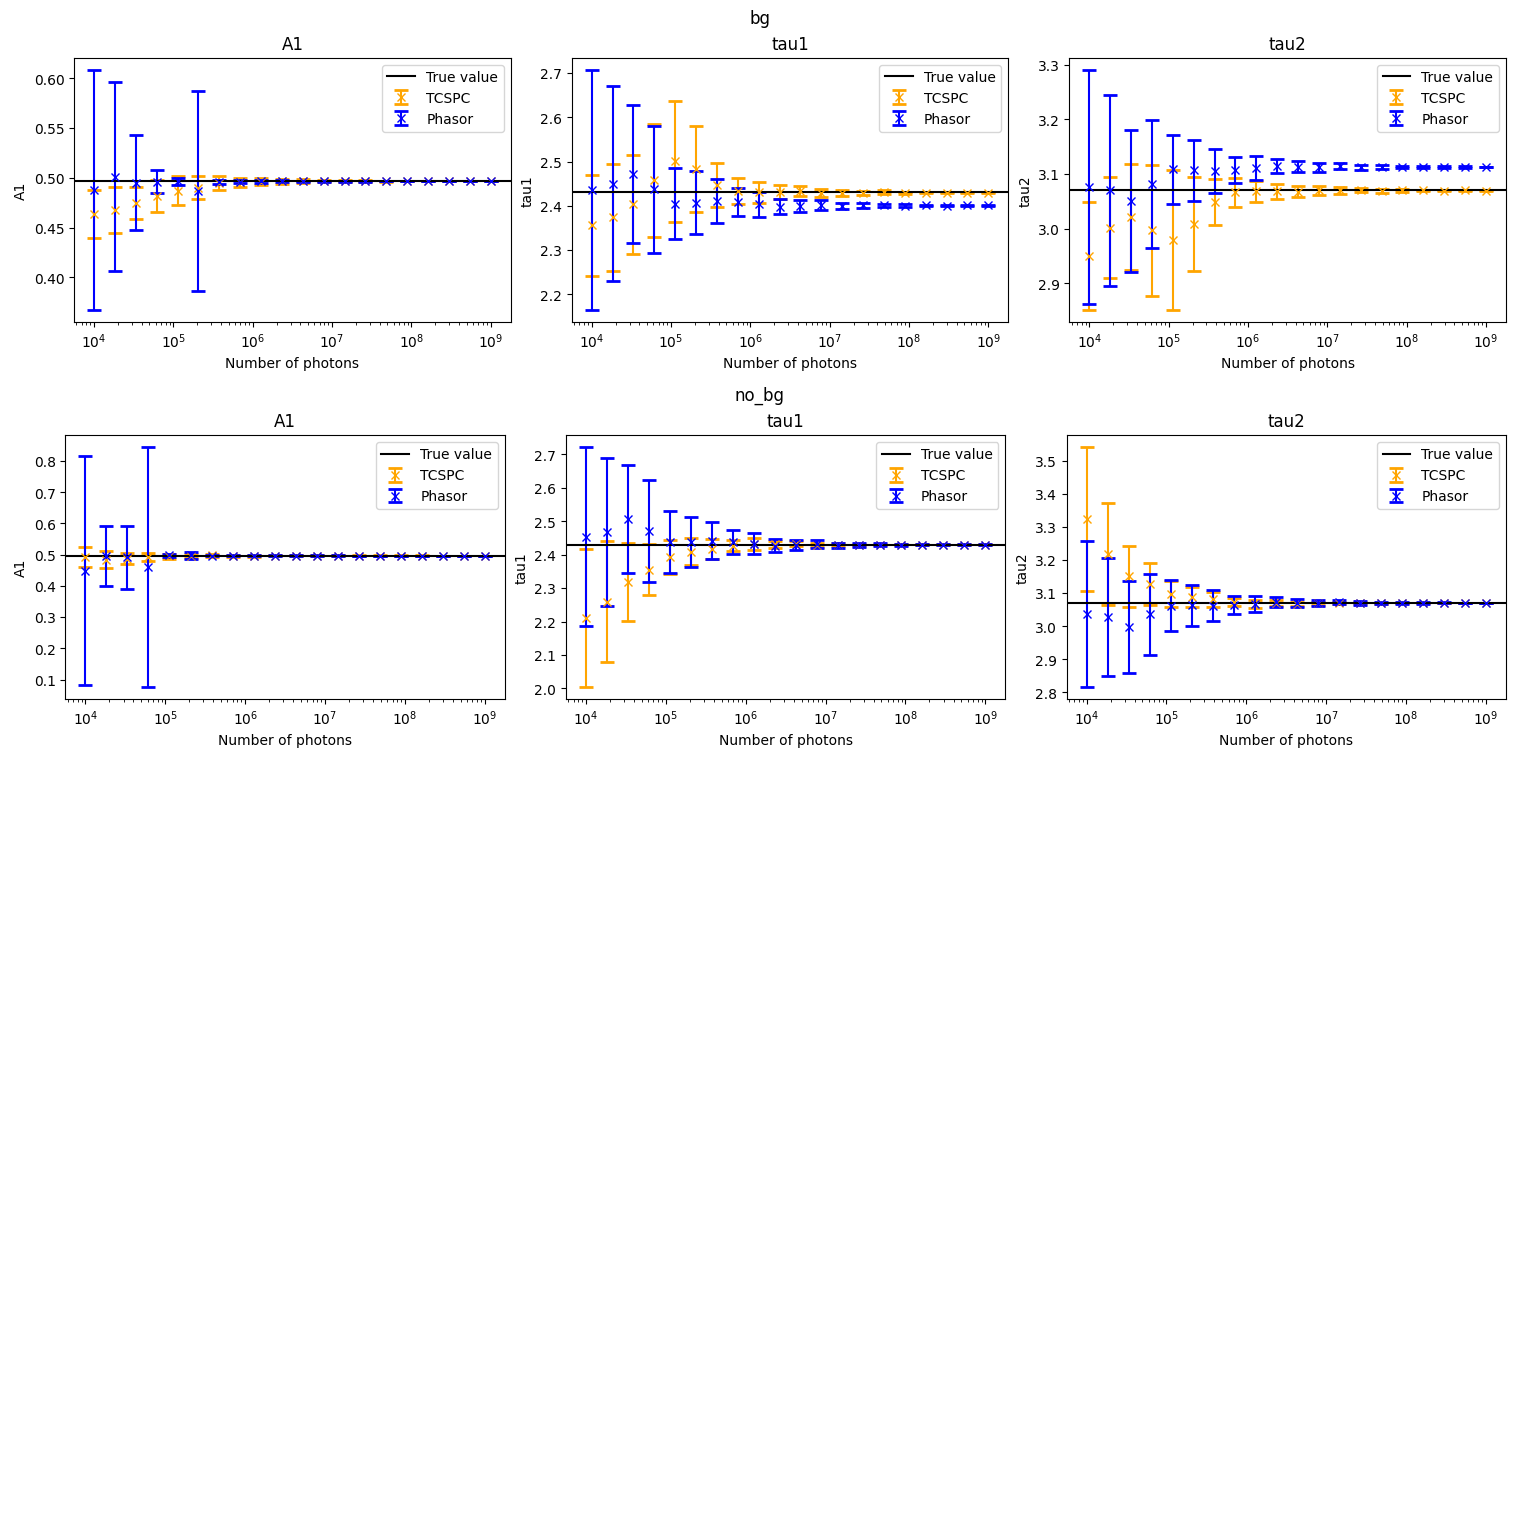

In [ ]:

mean_df1 = new_df1.groupby(level=0).mean()
std_df1 = new_df1.groupby(level=0).std()

mean_df2 = new_df2.groupby(level=0).mean()
std_df2 = new_df2.groupby(level=0).std()

fig = plt.figure( figsize=(15, 15))
big_axs = fig.subfigures(4,1)
true = [0.497,2.43,3.07]

cases = ['bg','no_bg']
for j in range(2):
    case = cases[j]
    big_axs[j].suptitle(case)
    for i in range(3):
        axs = big_axs[j].add_subplot(1, 3,i+1 )
        col = ['A1','tau1','tau2'][i] #column name
        axs.errorbar(n_photon_arr, mean_df1[(case,col)], yerr=std_df1[(case,col)], fmt='x', ecolor='orange', capthick=2,
                        capsize=5, color='orange', label='TCSPC')
        axs.errorbar(n_photon_arr, mean_df2[(case,col)], yerr=std_df2[(case,col)], fmt='x', ecolor='blue', capthick=2,
                        capsize=5, color='blue', label='Phasor')
        axs.axhline(y=true[i], color='k', linestyle='-', label='True value')
        axs.set_xscale('log')
        axs.set_xlabel('Number of photons')
        axs.set_ylabel(col)
        axs.set_title(col)
        axs.legend()

# Show the plot
plt.show()

In [ ]:
# Display the columns of the n_phasor_df DataFrame
print(n_phasor_df.columns)


MultiIndex([(   'bg',   'A1'),
            (   'bg', 'tau1'),
            (   'bg', 'tau2'),
            ('no_bg',   'A1'),
            ('no_bg', 'tau1'),
            ('no_bg', 'tau2')],
           )


In [ ]:
par_dict = {k:v.value for k,v in mi2.params.items()}
print("Keys in mi1.params:", list(mi2.params.keys()))  # Print the keys for debugging

A_sum = sum([par_dict[f'A{j}'] for j in range(1,N+1)])
for i in range(1,N+1):
  par_dict[f'A{i}']=par_dict[f'A{i}']/A_sum

Keys in mi1.params: ['c', 'A1', 'A2', 'tau1', 'tau2']


In [ ]:
par_dict

{'c': 2.256481357405502,
 'A1': 0.5050895513504691,
 'A2': 0.49491044864953093,
 'tau1': 2.454019967382707,
 'tau2': 3.0625032322317924}

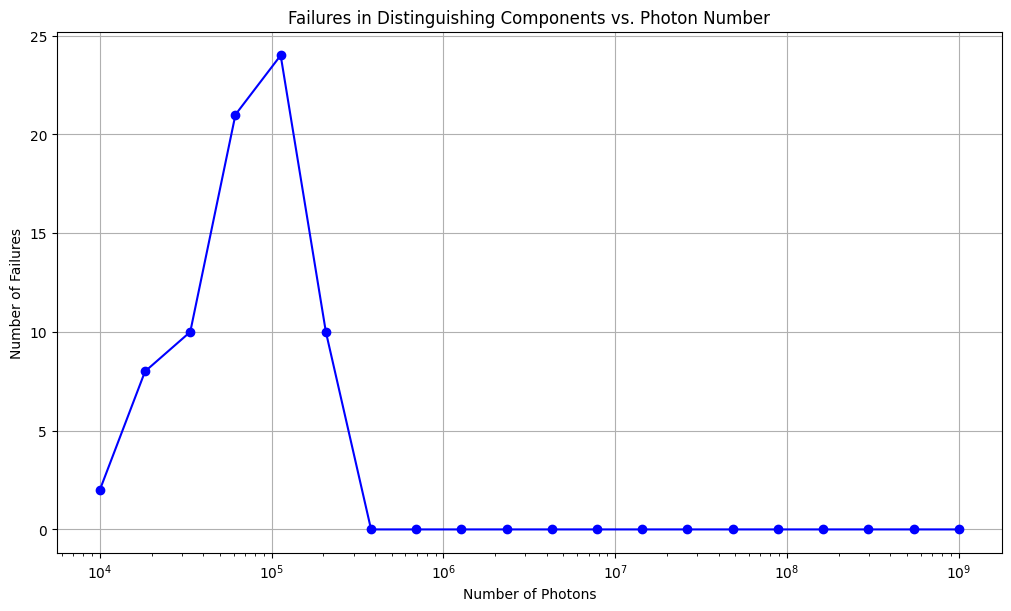

In [ ]:
# Reset failure_counts to ensure clean start
failure_counts = []

# Assuming n_photon_arr is defined and correctly populated
for n_photon in n_photon_arr:
    failures = 0
    for j in range(100):  # For each simulation
        EGFP.n_photon = n_photon
        EGFP.repeat_sim(100)
        # Assuming the simulation data EGFP.sim_data[j] is correctly populated
        # and MLEfit function works as expected
        fit_results_df = MLEfit(2, EGFP.t, EGFP.sim_data[j], method='powell', rescale=False)

        # Extract fitted values
        A1 = fit_results_df['A1'].iloc[0]
        A2 = fit_results_df['A2'].iloc[0]
        tau1 = fit_results_df['tau1'].iloc[0]
        tau2 = fit_results_df['tau2'].iloc[0]

        # Failure condition
        if np.isclose(tau1, tau2, atol=0.2) or A1 > 0.8 or A2 > 0.8:
            failures += 1

    failure_counts.append(failures)

# Plotting the number of failures vs. n_photon
plt.figure(figsize=(10, 6))
plt.plot(n_photon_arr, failure_counts, marker='o', linestyle='-', color='blue')
plt.xscale('log')
plt.xlabel('Number of Photons')
plt.ylabel('Number of Failures')
plt.title('Failures in Distinguishing Components vs. Photon Number')
plt.grid(True)
plt.show()